In [17]:
# Verificar dependencias
import importlib
missing = []
for pkg in ('gymnasium','ale_py','shimmy','torch','torchvision','opencv_python','matplotlib','numpy'):
    try:
        importlib.import_module(pkg)
    except Exception:
        missing.append(pkg)
if missing:
    print('Paquetes faltantes:', missing)
    print('Instálalos con: pip install -r requirements.txt')
else:
    print('✓ Dependencias instaladas')

import torch
import numpy as np

torch.serialization.add_safe_globals([np._core.multiarray.scalar])

Paquetes faltantes: ['opencv_python']
Instálalos con: pip install -r requirements.txt


In [18]:
# Imports y configuración
import os
import sys
from pathlib import Path
from collections import deque
import gymnasium as gym

proj_root = Path.cwd()
if str(proj_root) not in sys.path:
    sys.path.insert(0, str(proj_root))

from src.train_ac import train_ac_agent
from src.record import record_episode
from src.ac_agent import ActorCriticAgent
from src.utils import preprocess_frame, stack_frames
import matplotlib.pyplot as plt

print('Project root:', proj_root)

Project root: c:\Users\carlo\Downloads\RL_Galaxian


In [ ]:
# Parámetros de entrenamiento
EPISODES = 100
EMAIL = 'ang23010@uvg.edu.gt'
CHECKPOINT_DIR = 'checkpoints_ac'
ENV_NAME = 'ALE/Galaxian-v5'
DEVICE = 'cpu'
EARLY_STOP_PATIENCE = 200
MA_WINDOW = 20
SAVE_EVERY = 100

print('Parámetros Actor-Critic (Optimizados):')
print(f' EPISODES= {EPISODES}')
print(f' EARLY_STOP_PATIENCE= {EARLY_STOP_PATIENCE}')
print(f' MA_WINDOW= {MA_WINDOW}')
print(f' DEVICE= {DEVICE}')
print('✓ Learning rate: 3e-4 (mayor para aprender más rápido)')
print('✓ Entropy coef: 0.05 (más exploración)')


Parámetros Actor-Critic (Optimizados):
 EPISODES= 100
 EARLY_STOP_PATIENCE= 200
 MA_WINDOW= 20
 DEVICE= cpu
✓ Learning rate: 3e-4 (mayor para aprender más rápido)
✓ Entropy coef: 0.05 (más exploración)
✓ NO reward clipping (valores reales de Galaxian)


In [21]:
# Entrenamiento Actor-Critic
agent, results = train_ac_agent(
    episodes=EPISODES,
    email=EMAIL,
    checkpoint_dir=CHECKPOINT_DIR,
    env_name=ENV_NAME,
    early_stop_patience=EARLY_STOP_PATIENCE,
    ma_window=MA_WINDOW,
    save_every=SAVE_EVERY,
    device=DEVICE
)

Ep 1/100 | Reward: 1290.0 | MA_Reward: 1290.0 | A_Loss: -0.0273 | C_Loss: 1.0067 | Entropy: 1.7889
  ✓ Nuevo mejor MA_Reward: 1290.0 → Modelo guardado
Ep 2/100 | Reward: 690.0 | MA_Reward: 990.0 | A_Loss: 0.0006 | C_Loss: 0.9957 | Entropy: 1.7891
Ep 2/100 | Reward: 690.0 | MA_Reward: 990.0 | A_Loss: 0.0006 | C_Loss: 0.9957 | Entropy: 1.7891
Ep 3/100 | Reward: 1010.0 | MA_Reward: 996.7 | A_Loss: -0.0023 | C_Loss: 0.9696 | Entropy: 1.7887
Ep 3/100 | Reward: 1010.0 | MA_Reward: 996.7 | A_Loss: -0.0023 | C_Loss: 0.9696 | Entropy: 1.7887
Ep 4/100 | Reward: 1760.0 | MA_Reward: 1187.5 | A_Loss: 0.1888 | C_Loss: 0.8271 | Entropy: 1.7886
Ep 4/100 | Reward: 1760.0 | MA_Reward: 1187.5 | A_Loss: 0.1888 | C_Loss: 0.8271 | Entropy: 1.7886
Ep 5/100 | Reward: 480.0 | MA_Reward: 1046.0 | A_Loss: -0.4505 | C_Loss: 0.9706 | Entropy: 1.7893
Ep 5/100 | Reward: 480.0 | MA_Reward: 1046.0 | A_Loss: -0.4505 | C_Loss: 0.9706 | Entropy: 1.7893
Ep 6/100 | Reward: 580.0 | MA_Reward: 968.3 | A_Loss: -0.2141 | C_Los

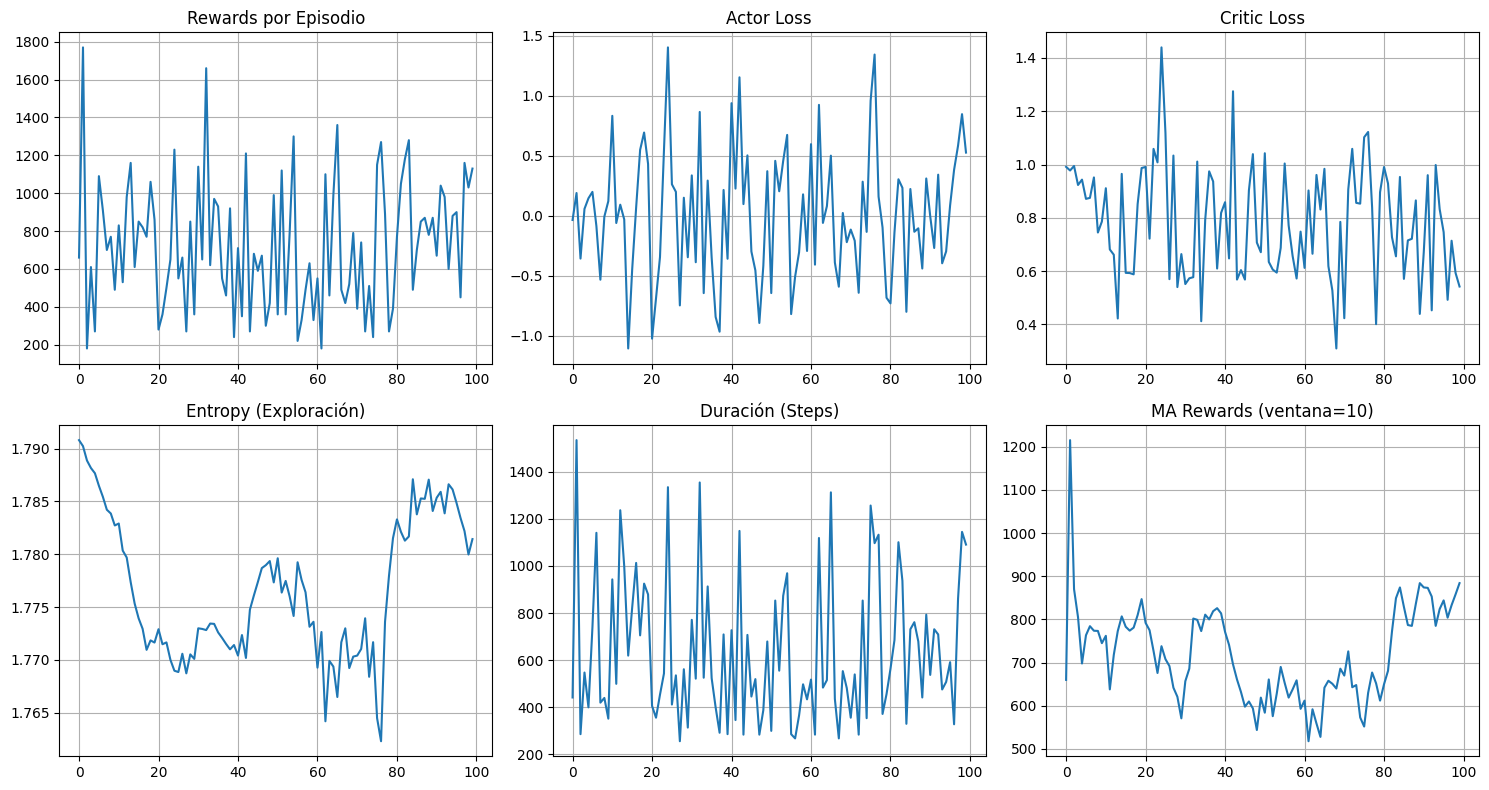

In [5]:
# Visualizar métricas
rewards = results.get('rewards', [])
actor_losses = results.get('actor_losses', [])
critic_losses = results.get('critic_losses', [])
entropies = results.get('entropies', [])
durations = results.get('durations', [])

fig, axes = plt.subplots(2, 3, figsize=(15, 8))

axes[0, 0].plot(rewards)
axes[0, 0].set_title('Rewards por Episodio')
axes[0, 0].grid(True)

axes[0, 1].plot(actor_losses)
axes[0, 1].set_title('Actor Loss')
axes[0, 1].grid(True)

axes[0, 2].plot(critic_losses)
axes[0, 2].set_title('Critic Loss')
axes[0, 2].grid(True)

axes[1, 0].plot(entropies)
axes[1, 0].set_title('Entropy (Exploración)')
axes[1, 0].grid(True)

axes[1, 1].plot(durations)
axes[1, 1].set_title('Duración (Steps)')
axes[1, 1].grid(True)

# Moving average de rewards
if len(rewards) >= 10:
    ma_rewards = [np.mean(rewards[max(0, i-9):i+1]) for i in range(len(rewards))]
    axes[1, 2].plot(ma_rewards)
    axes[1, 2].set_title('MA Rewards (ventana=10)')
    axes[1, 2].grid(True)

plt.tight_layout()
plt.savefig(os.path.join(CHECKPOINT_DIR, 'training_metrics_ac.png'), dpi=300)
plt.show()

## Reentrenamiento (Continuar desde modelo guardado)

In [ ]:
# Parámetros de reentrenamiento
RESUME_MODEL = os.path.join(CHECKPOINT_DIR, f'final_model_ac_ang23010.pth')
ADDITIONAL_EPISODES = 200
EARLY_STOP_PATIENCE_RESUME = 100
MA_WINDOW_RESUME = 20
SAVE_EVERY_RESUME = 50

os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# Crear entorno y agente
env = gym.make(ENV_NAME)
n_actions = env.action_space.n
state_shape = (4, 84, 84)

agent_resume = ActorCriticAgent(state_shape, n_actions, device=DEVICE)

# Cargar modelo
if os.path.exists(RESUME_MODEL):
    print(f'Cargando modelo AC desde {RESUME_MODEL}')
    agent_resume.load(RESUME_MODEL)
    print(' Modelo cargado exitosamente')
else:
    print(f' Modelo no encontrado: {RESUME_MODEL}')
    raise FileNotFoundError(f'No existe {RESUME_MODEL}')

# Tracking
best_ma = -np.inf
no_improve = 0
stacked = deque(maxlen=4)

rewards = []
actor_losses = []
critic_losses = []
entropies = []
durations = []

# Loop de reentrenamiento
for ep in range(1, ADDITIONAL_EPISODES + 1):
    state, _ = env.reset()
    processed = preprocess_frame(state)
    state_stack = stack_frames(stacked, processed, True)

    done = False
    truncated = False
    ep_reward = 0.0
    ep_steps = 0

    agent_resume.reset_trajectory()

    while not (done or truncated):
        action = agent_resume.select_action(state_stack, training=True)
        next_state, reward, done, truncated, _ = env.step(action)

        processed = preprocess_frame(next_state)
        next_stack = stack_frames(stacked, processed, False)

        # NO clipear reward - valores reales de Galaxian
        agent_resume.store_reward_done(reward, done or truncated)

        ep_reward += reward
        ep_steps += 1
        state_stack = next_stack

    # Train
    actor_loss, critic_loss, entropy = agent_resume.train_step()

    rewards.append(ep_reward)
    durations.append(ep_steps)
    if actor_loss is not None:
        actor_losses.append(actor_loss)
        critic_losses.append(critic_loss)
        entropies.append(entropy)

    # Moving average
    if len(rewards) >= MA_WINDOW_RESUME:
        ma = np.mean(rewards[-MA_WINDOW_RESUME:])
    else:
        ma = np.mean(rewards) if rewards else -np.inf

    # Format losses for printing
    a_loss_str = f"{actor_loss:.4f}" if actor_loss is not None else "0.0000"
    c_loss_str = f"{critic_loss:.4f}" if critic_loss is not None else "0.0000"
    
    print(f'Resume Ep {ep} | Reward: {ep_reward:.1f} | MA: {ma:.1f} | '
          f'A_Loss: {a_loss_str} | C_Loss: {c_loss_str} | Entropy: {entropy:.4f}')

    # Guardar mejor modelo
    if ma > best_ma:
        best_ma = ma
        no_improve = 0
        email_prefix = EMAIL.split('@')[0]
        best_path = os.path.join(CHECKPOINT_DIR, f'best_model_ac_{email_prefix}.pth')
        agent_resume.save(best_path)
        print(f'  ✓ Nuevo mejor MA: {ma:.1f} → Modelo guardado')
    else:
        no_improve += 1

    # Checkpoints periódicos
    if ep % SAVE_EVERY_RESUME == 0:
        email_prefix = EMAIL.split('@')[0]
        cp_path = os.path.join(CHECKPOINT_DIR, f'checkpoint_ac_resume_ep{ep}_{email_prefix}.pth')
        agent_resume.save(cp_path)
        print(f'  → Checkpoint guardado: ep{ep}')

    # Early stopping
    if no_improve >= EARLY_STOP_PATIENCE_RESUME:
        print(f'Early stopping: {no_improve} episodios sin mejora')
        break

# Guardar modelo final
email_prefix = EMAIL.split('@')[0]
final_path = os.path.join(CHECKPOINT_DIR, f'final_model_ac_{email_prefix}.pth')
agent_resume.save(final_path)
print(f'\n✓ Reentrenamiento completado. Modelo final: {final_path}')

env.close()


📂 Cargando modelo AC desde checkpoints_ac\final_model_ac_ang23010.pth
✓ Modelo cargado exitosamente
Resume Ep 1 | Reward: 570.0 | MA: 570.0 | A_Loss: -0.9460 | C_Loss: 0.8667
  ✓ Nuevo mejor MA: 570.0 → Modelo guardado
Resume Ep 1 | Reward: 570.0 | MA: 570.0 | A_Loss: -0.9460 | C_Loss: 0.8667
  ✓ Nuevo mejor MA: 570.0 → Modelo guardado
Resume Ep 2 | Reward: 1180.0 | MA: 875.0 | A_Loss: -0.4603 | C_Loss: 0.7877
Resume Ep 2 | Reward: 1180.0 | MA: 875.0 | A_Loss: -0.4603 | C_Loss: 0.7877
  ✓ Nuevo mejor MA: 875.0 → Modelo guardado
  ✓ Nuevo mejor MA: 875.0 → Modelo guardado
Resume Ep 3 | Reward: 570.0 | MA: 773.3 | A_Loss: -0.8155 | C_Loss: 0.5532
Resume Ep 3 | Reward: 570.0 | MA: 773.3 | A_Loss: -0.8155 | C_Loss: 0.5532
Resume Ep 4 | Reward: 630.0 | MA: 737.5 | A_Loss: -1.1353 | C_Loss: 1.1964
Resume Ep 4 | Reward: 630.0 | MA: 737.5 | A_Loss: -1.1353 | C_Loss: 1.1964
Resume Ep 5 | Reward: 810.0 | MA: 752.0 | A_Loss: -0.2807 | C_Loss: 0.7048
Resume Ep 5 | Reward: 810.0 | MA: 752.0 | A_Los

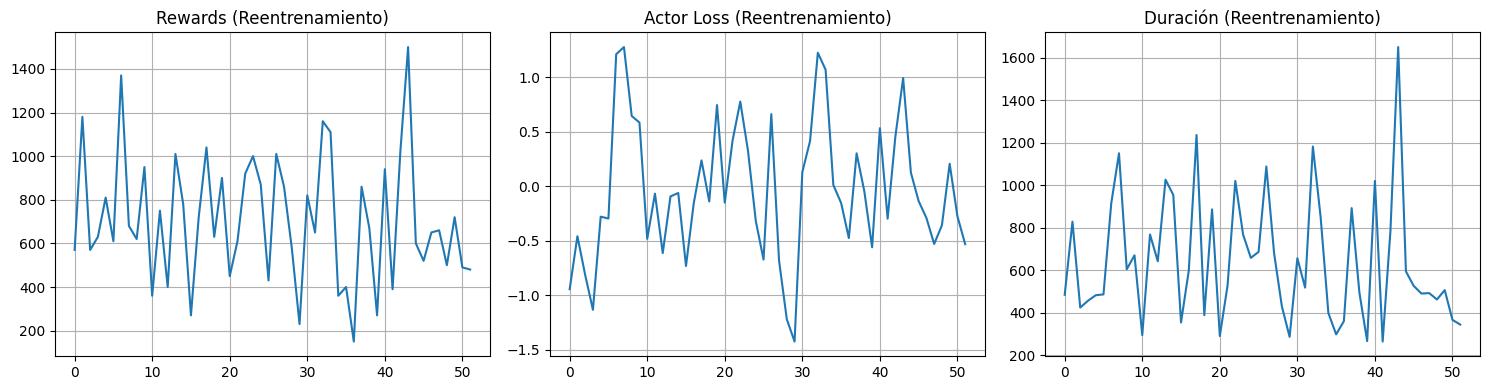

In [15]:
# Visualizar métricas de reentrenamiento
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(rewards)
axes[0].set_title('Rewards (Reentrenamiento)')
axes[0].grid(True)

axes[1].plot(actor_losses)
axes[1].set_title('Actor Loss (Reentrenamiento)')
axes[1].grid(True)

axes[2].plot(durations)
axes[2].set_title('Duración (Reentrenamiento)')
axes[2].grid(True)

plt.tight_layout()
plt.savefig(os.path.join(CHECKPOINT_DIR, 'retrain_metrics_ac.png'), dpi=300)
plt.show()

## Grabar episodio con el mejor modelo

In [ ]:
# Grabar episodio con mejor modelo AC
email_prefix = EMAIL.split('@')[0]
best_model_path = os.path.join(CHECKPOINT_DIR, f'final_model_ac_{email_prefix}.pth')

if os.path.exists(best_model_path):
    print(f' Cargando mejor modelo AC desde: {best_model_path}')
    
    state_shape = (4, 84, 84)
    n_actions = 6
    
    agent_test = ActorCriticAgent(state_shape, n_actions, device=DEVICE)
    agent_test.load(best_model_path)
    
    video_path = record_episode(agent_test, email=EMAIL, output_dir='videos_ac', env_name=ENV_NAME)
    print(f'\n✓ Video guardado en: {video_path}')
else:
    print(f' No se encontró el modelo: {best_model_path}')

🎬 Cargando mejor modelo AC desde: checkpoints_ac\final_model_ac_ang23010.pth
Video saved: videos_ac\ang23010_20251117170934_340.mp4
Score: 340 | Frames: 871

✓ Video guardado en: videos_ac\ang23010_20251117170934_340.mp4
Video saved: videos_ac\ang23010_20251117170934_340.mp4
Score: 340 | Frames: 871

✓ Video guardado en: videos_ac\ang23010_20251117170934_340.mp4
